# Experimentação com remoção dos Outliers

Neste notebook é utilizado o ```dataset v2```, que foi realizado a removção das instâncias com idade superior de 77 anos.

In [1]:
import pandas as pd
import joblib

from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from src.data.dataset import Dataset
from src.models.train_model import Trainer

from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree



INPUT_PATH = "../data/processed/"
VERSION = "v2"
NUMERIC_FEATURES = []
CATEGORICAL_FEATURES = ['uf', 'periodo', 'clima','tipo_pista', 'tipo_veiculo', 'grupo_idade', 'sexo', 'feriado']
FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES
TARGET = "mortos"
COLUNMS = FEATURES + [ TARGET ]

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boost": GradientBoostingClassifier(random_state=42),
}


In [2]:
spark = SparkSession.builder.appName("ds-classify").getOrCreate()
dataset = spark.read.parquet(f"{INPUT_PATH}/dataset_{VERSION}.parquet")
dataset.show()

24/03/15 21:23:44 WARN Utils: Your hostname, AGM-595277.local resolves to a loopback address: 127.0.0.1; using 192.168.0.100 instead (on interface en0)
24/03/15 21:23:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/15 21:23:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---+-------+-------+-----------+---------------+-----------+---------+-------+------+
| uf|periodo|  clima| tipo_pista|   tipo_veiculo|grupo_idade|     sexo|feriado|mortos|
+---+-------+-------+-----------+---------------+-----------+---------+-------+------+
| SP|noturno| normal|    simples|       Caminhão|      25-34|Masculino|    nao|     0|
| BA| diurno|adverso|    simples|Caminhão-trator|      35-44|Masculino|    nao|     0|
| PR|noturno| normal|nao_simples|       Caminhão|      45-64|Masculino|    nao|     0|
| GO| diurno| normal|    simples|Caminhão-trator|      35-44|Masculino|    nao|     0|
| MG| diurno| normal|    simples|       Caminhão|      25-34|Masculino|    nao|     0|
| RS| diurno| normal|    simples|Caminhão-trator|      45-64|Masculino|    nao|     0|
| CE|noturno| normal|    simples|Caminhão-trator|      25-34|Masculino|    nao|     0|
| PE|noturno| normal|    simples|       Caminhão|      45-64|Masculino|    nao|     0|
| RJ|noturno| normal|    simples|       Cam

In [3]:
df = dataset.select(COLUNMS).toPandas()

## Criando Dataset

In [4]:

dataset_train = Dataset(
    data=df,
    features=FEATURES,
    target=TARGET,
    test_size=0.2,
)

dataset_validation = dataset_train.get_validation_data()

In [5]:
print("{} training instances ".format(len(dataset_train.training[0])))
print("{} testing instances ".format(len(dataset_train.testing[0])))
print("{} validation instances ".format(len(dataset_validation.testing[0])))

71777 training instances 
17945 testing instances 
7178 validation instances 


## Pre Processamento

In [6]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_FEATURES),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_FEATURES),
    ]
)

## Treinamento


In [7]:

trainer = Trainer(
    models=models, 
    preprocessor=preprocessor,
    path_reports=f"../models/{VERSION}"
)

trainer.train(dataset=dataset_train)

## Resultados

### Matriz de Confusão

------------------- Resultados ----------------------------
Decision Tree Score: 0.86
Decision Tree CV Score: 0.83
Random Forest Score: 0.86
Random Forest CV Score: 0.84
Gradient Boost Score: 0.72
Gradient Boost CV Score: 0.71


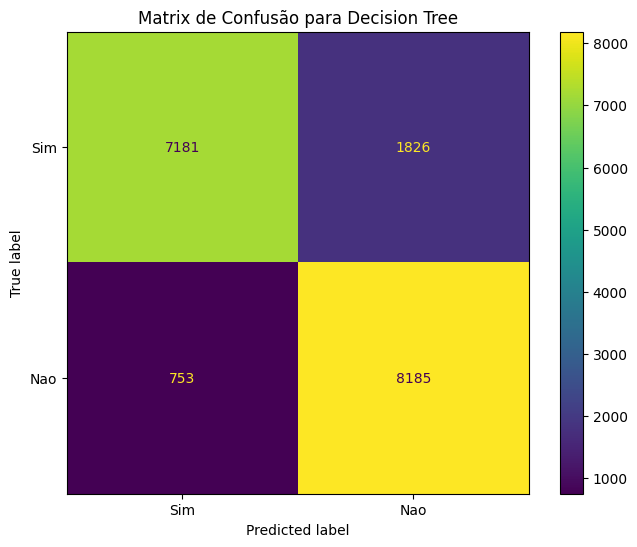

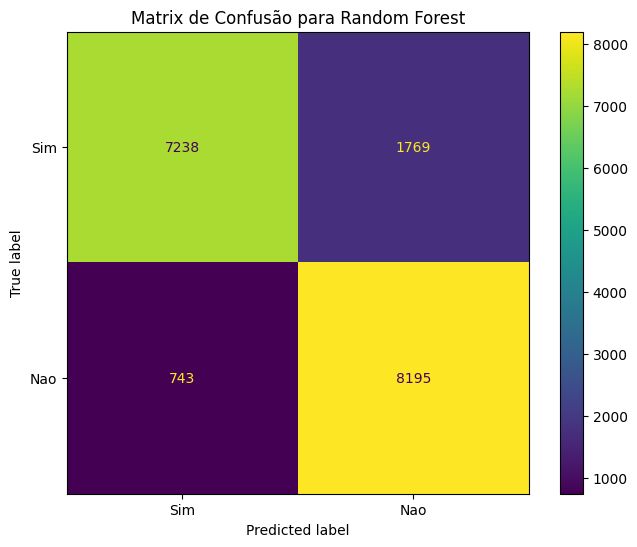

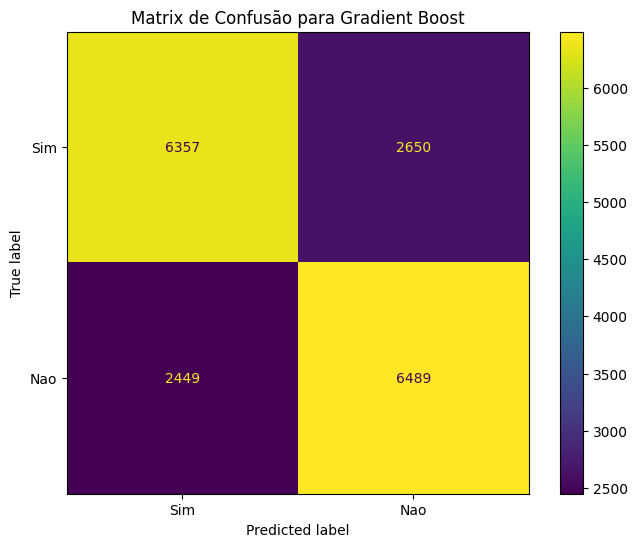

In [8]:
trainer.plot_results()

### Curva ROC

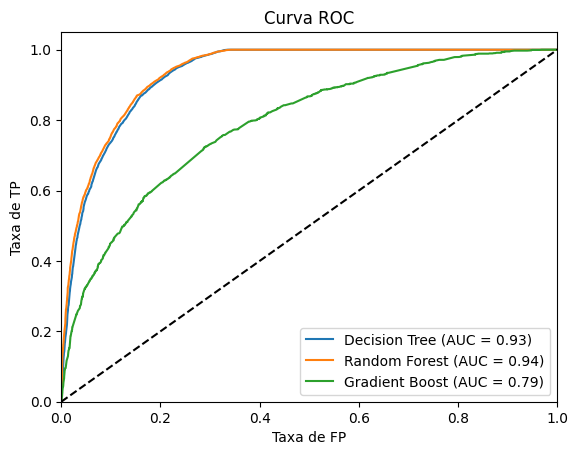

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/ds-classify-accident/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [9]:
trainer.plot_roc_auc()

### Seleção do Modelo

In [10]:
pipeline = trainer.get_model("Random Forest")

### Importância de Features

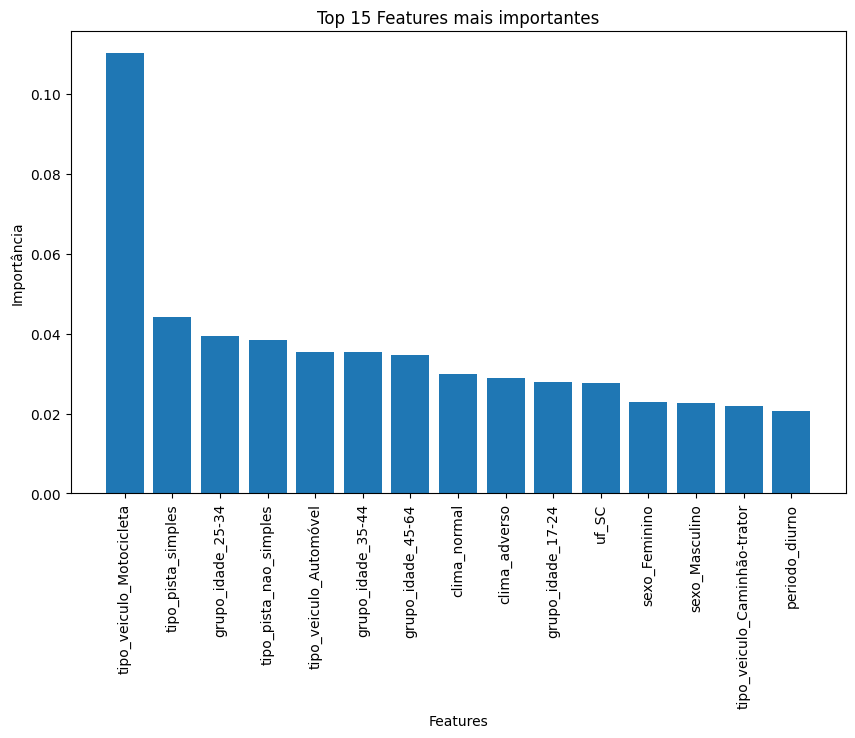

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

feature_importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(input_features=CATEGORICAL_FEATURES)

importance = {feature: importance for feature, importance in zip(feature_names, feature_importances)}
sorted_importance = dict(sorted(importance.items(), key=lambda x: x[1] if x[1] is not None else float('-inf'), reverse=True))

feature_names = list(sorted_importance.keys())[:15]
feature_importances = list(sorted_importance.values())[:15]
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importância')
plt.title('Top 15 Features mais importantes')
plt.xticks(rotation=90)
plt.show()
plt.savefig(f"../models/{VERSION}/feature_importance.png")



### Visualização da Arvore de Decisão

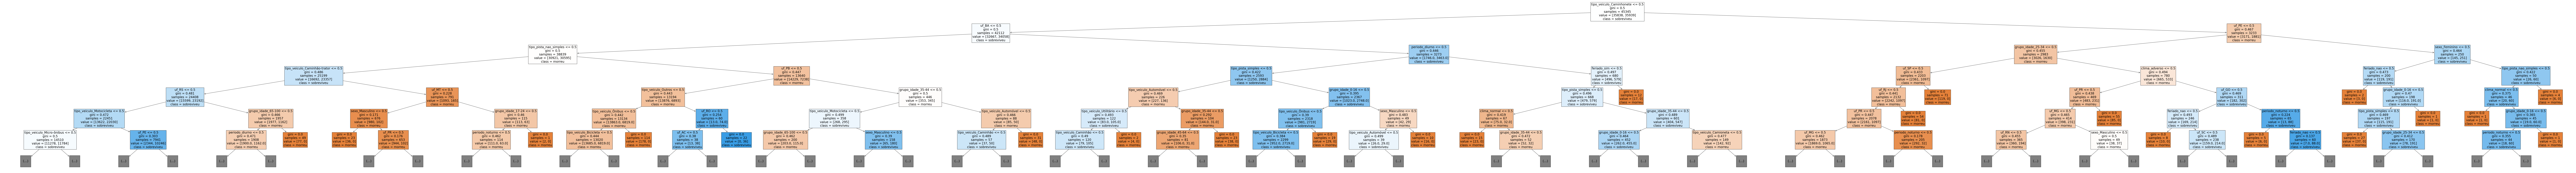

<Figure size 640x480 with 0 Axes>

In [12]:


tree = pipeline.named_steps['classifier'].estimators_[0]
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(input_features=CATEGORICAL_FEATURES)

plt.figure(figsize=(300, 20)) 
plot_tree(tree, max_depth=6, feature_names=feature_names, fontsize=20, class_names=["morreu", "sobreviveu"],filled=True)

plt.show()

plt.savefig(f"../models/{VERSION}/tree.png")


### Salvando o Modelo

In [13]:

joblib.dump(pipeline, f"../models/{VERSION}/accident_classifier_v2.sav")

['../models/v2/accident_classifier_v2.sav']